In [157]:
import numpy as np

from sigvisa import Sigvisa
from sigvisa.source.event import get_event
from sigvisa.infer.coarse_to_fine_init import ModelSpec, EventRunSpec, TimeRangeRunSpec, do_coarse_to_fine, initialize_from, do_inference, initialize_sg
from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.treegp.gp import GPCov
from sigvisa.graph.region import Region

import os, sys, traceback
import cPickle as pickle

%matplotlib inline
import matplotlib.pylab as plt

In [23]:
# create an sg with appropriate models
region_lon = (-126, -100)
region_lat = (32, 49)
region_stime = 1202151900.0
region_etime = region_stime + 1000.0

min_mb = 4.0
uatemplate_rate=1e-4
hz = 10.0
runid=14
phases=["P", ]
stas=["ULM",]

region = Region(lons=region_lon, lats=region_lat,
                times=(region_stime, region_etime),
                rate_bulletin="isc",
                rate_train_start=1167609600,
                rate_train_end=1199145600)

rs = TimeRangeRunSpec(sites=stas, start_time=region_stime, end_time=region_etime)

ms1 = ModelSpec(template_model_type="gpparam",
                wiggle_model_type="gplocal+lld+none",
                wiggle_family="db4_2.0_3_20.0",
                uatemplate_rate=uatemplate_rate,
                max_hz=hz,
                phases=phases,
                runids=(runid,),
                inference_region=region,
                dummy_fallback=True,
                hack_param_constraint=True,
                min_mb=min_mb,
                raw_signals=True,
                vert_only=True)
sg = rs.build_sg(ms1)


loading sta ULM chan auto time [1202151900.0, 1202153400.0]  ... successfully loaded.


In [24]:
evs = [sg.prior_sample_event() for i in range(100)]
evs[0].time = region_stime + 1.0
evnodes = sg.add_event(evs[0])

tmpl_nodes = [n for n in sg.extended_evnodes[1] if n not in evnodes.values() and not n.deterministic()]
wns = [sg.station_waves[s][0] for s in stas]

for wn in wns:
    wn.unfix_value()

In [25]:
def predict_signal():
    for n in tmpl_nodes:
        n.parent_predict()
    for wn in wns:
        wn.parent_predict()
        
    v, _ = wn.get_template_params_for_arrival(1, "P")
    atime = v["arrival_time"]
    aidx = int((atime-wn.st)*wn.srate)
    signal = wn.get_value()[aidx-50 : aidx + 600]
    return signal.copy()

def sample_signal():
    for n in tmpl_nodes:
        n.parent_sample()
    for wn in wns:
        wn.parent_sample()
        
    v, _ = wn.get_template_params_for_arrival(1, "P")
    atime = v["arrival_time"]
    aidx = int((atime-wn.st)*wn.srate)
    signal = wn.get_value()[aidx-50 : aidx + 600]
    return signal.copy()

pred_signals = []
sampled_signals = []
for i, ev in enumerate(evs):
    ev.mb = 4.0
    ev.time = region_stime + 1.0
    try:
        sg.set_event(1, ev)
    except:
        continue
    pred_signal = predict_signal()
    sampled_signal = sample_signal()
    
    pred_signals.append(pred_signal)
    sampled_signals.append(sampled_signal)

sg.remove_event(1)

sampling w/ seed 294644147
sampling w/ seed 1763543676
sampling w/ seed 1822036853
sampling w/ seed 1690617917
sampling w/ seed 1507740750
sampling w/ seed 1782067143
sampling w/ seed 1554421406
sampling w/ seed 529623982
sampling w/ seed 825734879
sampling w/ seed 1710873460
sampling w/ seed 742784857
sampling w/ seed 1695946076
sampling w/ seed 527051964
sampling w/ seed 308203375
sampling w/ seed 911658399
sampling w/ seed 1388694306
sampling w/ seed 213365119
sampling w/ seed 1258837180
sampling w/ seed 689659727
sampling w/ seed 1259363483
sampling w/ seed 1743368764
sampling w/ seed 186930400
sampling w/ seed 107273996
sampling w/ seed 1250315550
sampling w/ seed 2121859514
sampling w/ seed 975872865
sampling w/ seed 1490184710
sampling w/ seed 1119089164
sampling w/ seed 2092151486
sampling w/ seed 2116165228
sampling w/ seed 1088007899
sampling w/ seed 897065854
sampling w/ seed 624939539
sampling w/ seed 102210437
sampling w/ seed 924403603
sampling w/ seed 109995063
sampling 

In [149]:
correlated_ps = []
correlated_ss = []
correlated_evs = []

for i, (ps, ss) in enumerate(zip(pred_signals, sampled_signals)):
    
    pps = (ps / np.linalg.norm(ps))[:300]
    sss = (ss / np.linalg.norm(ss))[:300]
    xc = np.dot(pps, sss)
    
    if xc > 0.1:
        correlated_ps.append(pps)
        correlated_ss.append(sss)
        correlated_evs.append(evs[i])
        
n_correlated = len(correlated_evs)

In [150]:
from sigvisa.infer.correlations.historical_signal_library import get_historical_signals
from sigvisa.infer.correlations.ar_correlation_model import estimate_ar, ar_advantage, iid_advantage
from sigvisa.infer.correlations.weighted_event_posterior import build_ttr_model_array, hack_ev_time_posterior_with_weight

proposals = get_historical_signals(sg, "P")

In [151]:
phase = "P"

all_origin_lls = [[] for i in range(n_correlated)]
    
for i, (x, signals) in enumerate(proposals):
    c = signals[(wn.sta, wn.chan, wn.band)]
    tt_array, tt_mean = build_ttr_model_array(sg, x, wn.sta, wn.srate, phase=phase)
    
    for j, sdata in enumerate(correlated_ss):
        sta_lls = dict()        
        lls = ar_advantage(sdata, c, wn.nm)
        sta_lls[wn.label] = (lls, tt_array, tt_mean)
        all_origin_lls[j].append((x, sta_lls))
    if i % 10 == 0:
        print i

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720


In [154]:
global_srate = 1.0
global_stime = sg.inference_region.stime - 400
N = 900

def get_proposal_weights(origin_lls):
    proposal_otime_likelihoods = [hack_ev_time_posterior_with_weight(sg, x, sta_lls, stas=stas,
                                                                         N=N,
                                                                         global_stime = global_stime,
                                                                         global_srate = global_srate,
                                                                         temper=1.0) for (x, sta_lls) in origin_lls]

    proposal_weights = []
    proposal_otime_posteriors = []
    for ll in proposal_otime_likelihoods:
        C = np.max(ll)
        posterior = np.exp(ll-C)
        Z = np.sum(posterior)
        posterior /= Z
        logZ = np.log(Z) + C
        proposal_weights.append(logZ)
        proposal_otime_posteriors.append(posterior)


    proposal_weights = np.array(proposal_weights)
    proposal_weights /= 10
    proposal_weights -= np.max(proposal_weights)
    proposal_weights = np.exp(proposal_weights)
    proposal_weights += 0.05/len(origin_lls)
                               # regularize the proposal distribution:
                               # the effect of this is that roughly 5%
                               # of the time we will propose from a
                               # uniform distribution over all
                               # candidates.
    proposal_weights /= np.sum(proposal_weights)
    n = len(proposal_weights)
    return proposal_weights

pw = [get_proposal_weights(origin_lls) for origin_lls in all_origin_lls]


In [155]:
training_xs = np.array([x for (x, sta_lls) in origin_lls]).reshape((-1, 5))

ULM -20 -20 -95.874956 50.250261
ULM -20 -20 -95.874956 50.250261
ULM -20 -20 -95.874956 50.250261
ULM -20 -20 -95.874956 50.250261
ULM -20 -20 -95.874956 50.250261
ULM -20 -20 -95.874956 50.250261
ULM -20 -20 -95.874956 50.250261
ULM -20 -20 -95.874956 50.250261
ULM -20 -20 -95.874956 50.250261
ULM -20 -20 -95.874956 50.250261
ULM -20 -20 -95.874956 50.250261
ULM -20 -20 -95.874956 50.250261
ULM -20 -20 -95.874956 50.250261
ULM -20 -20 -95.874956 50.250261
ULM -20 -20 -95.874956 50.250261


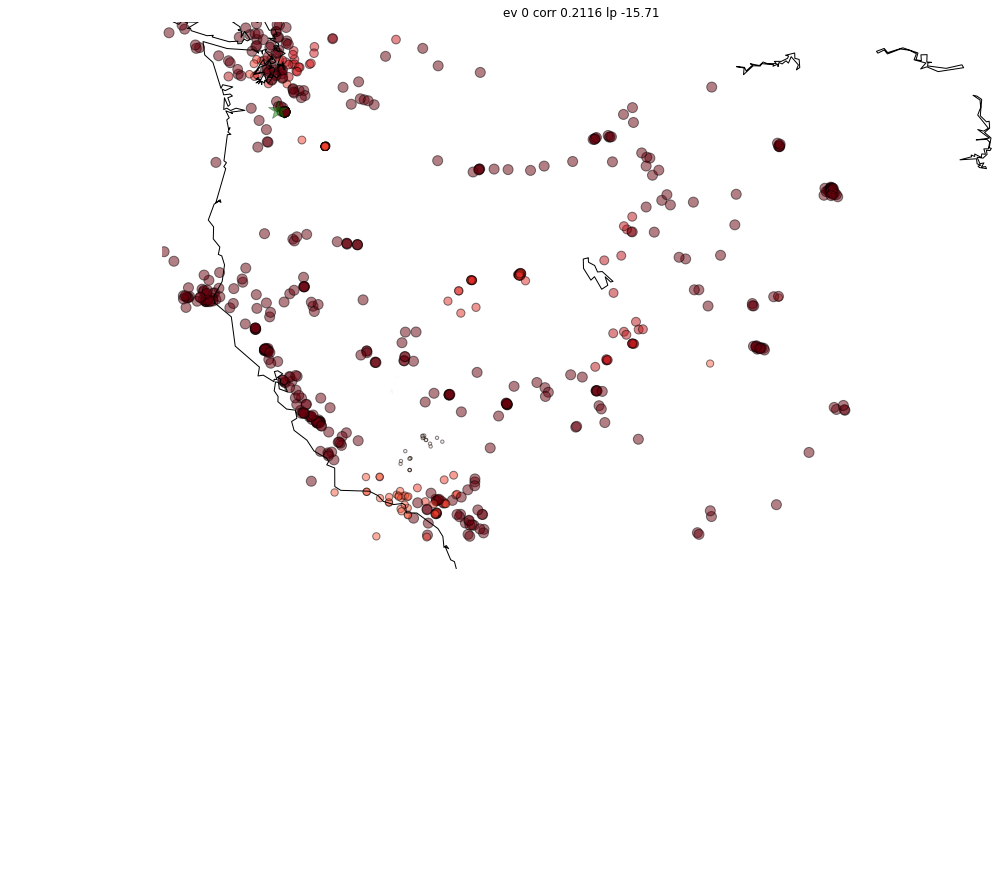

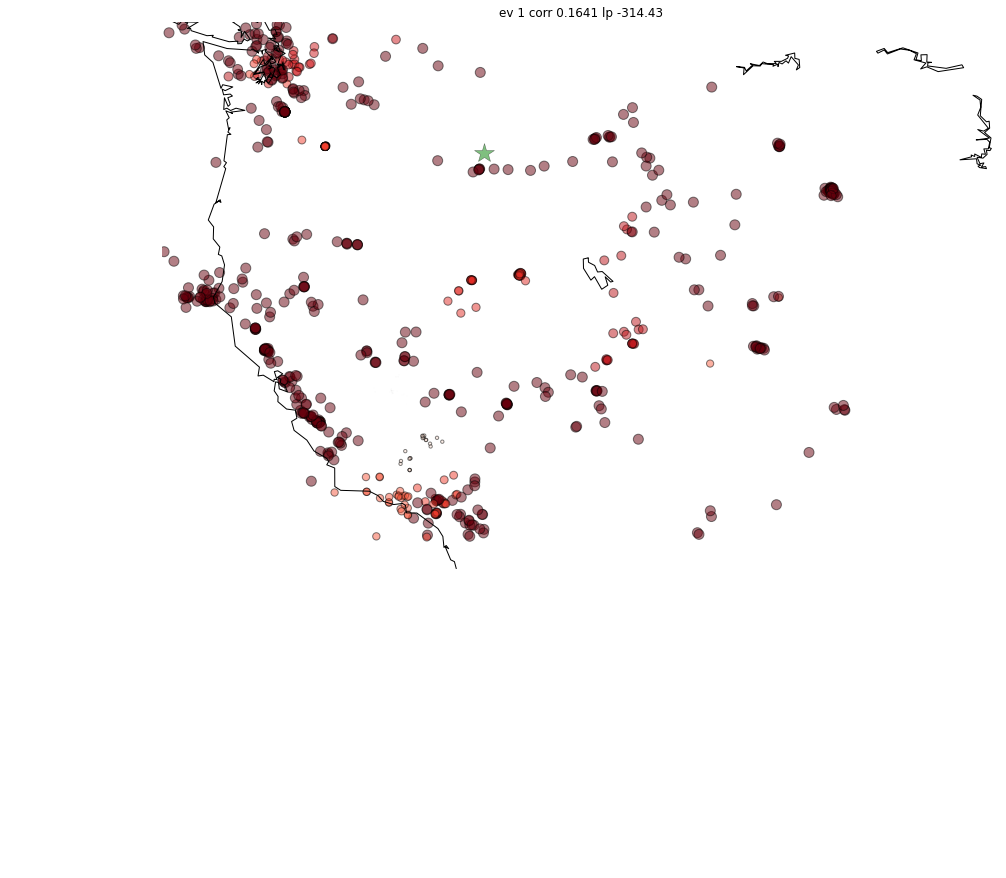

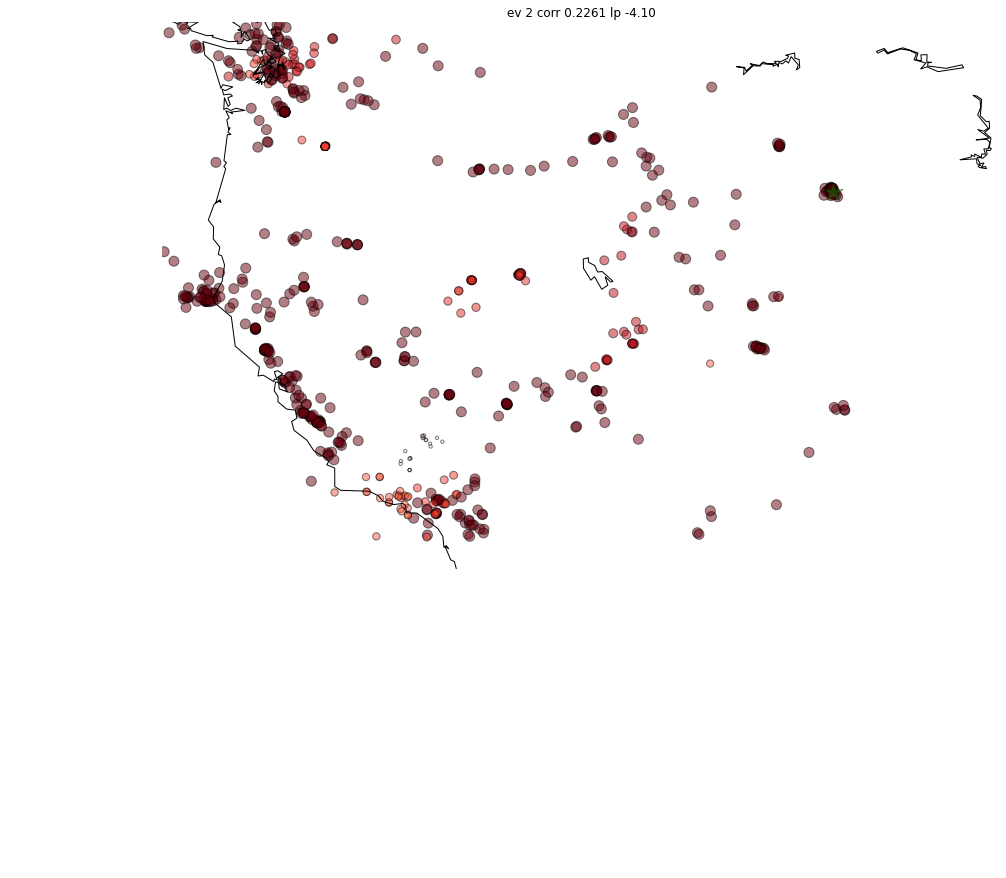

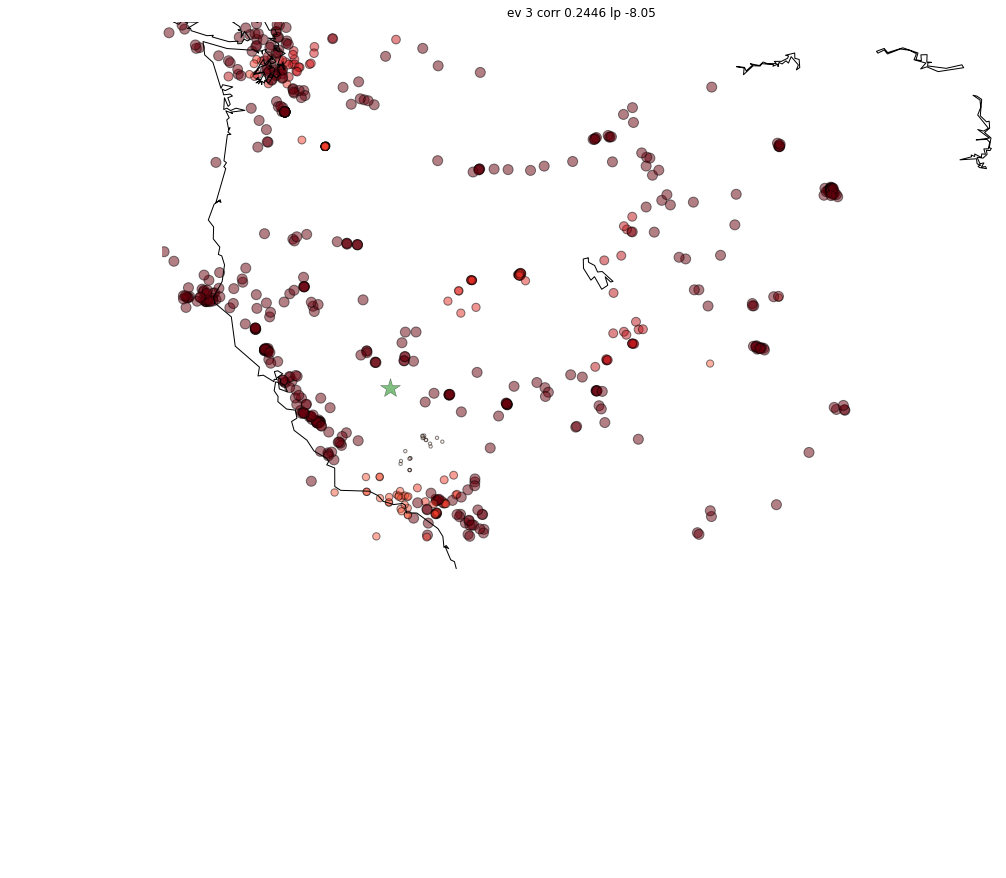

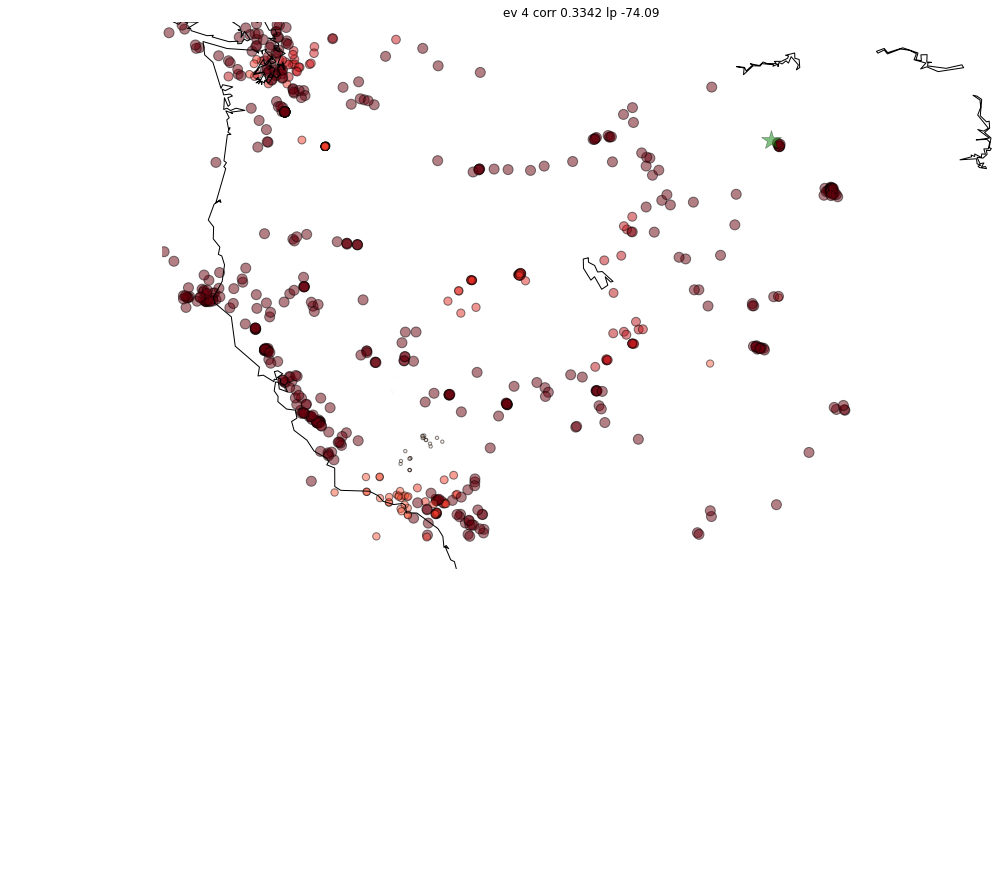

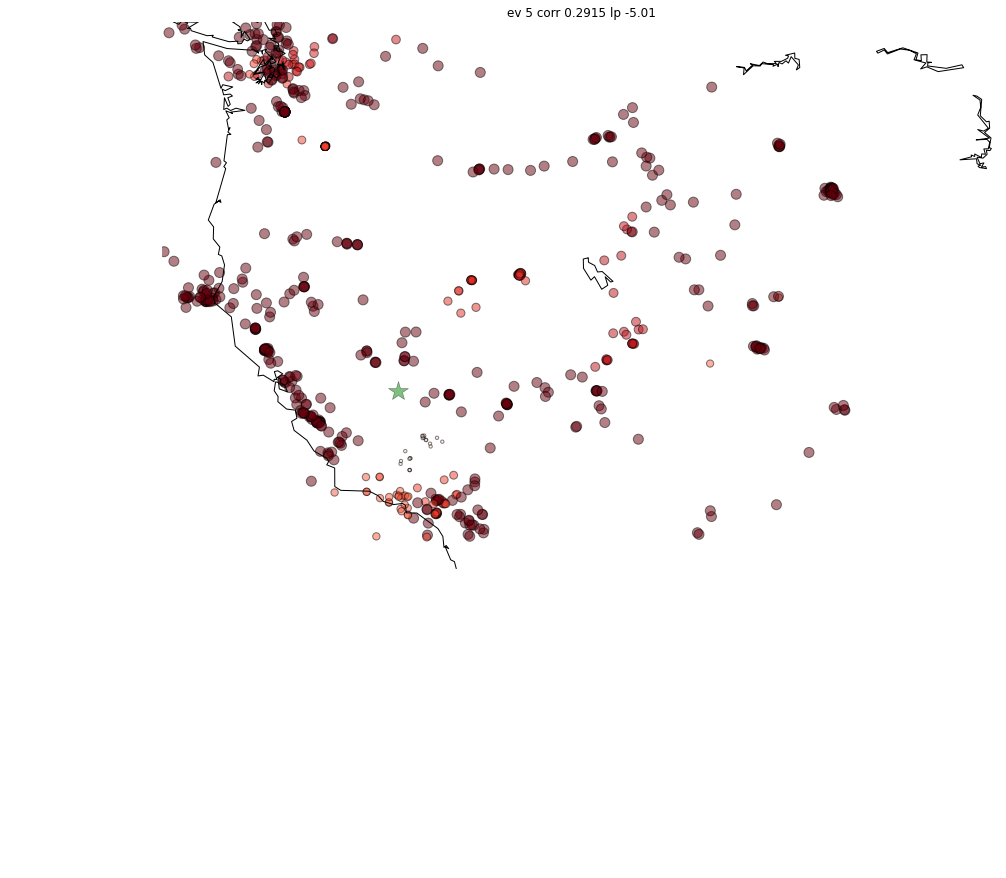

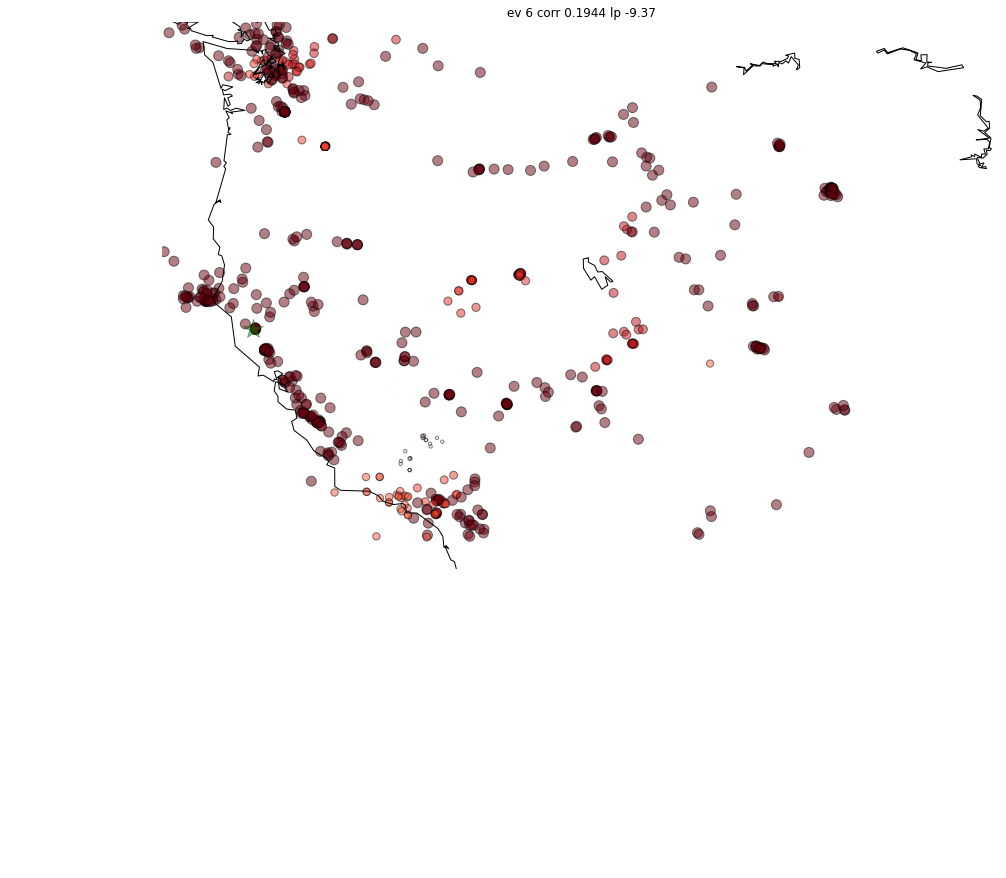

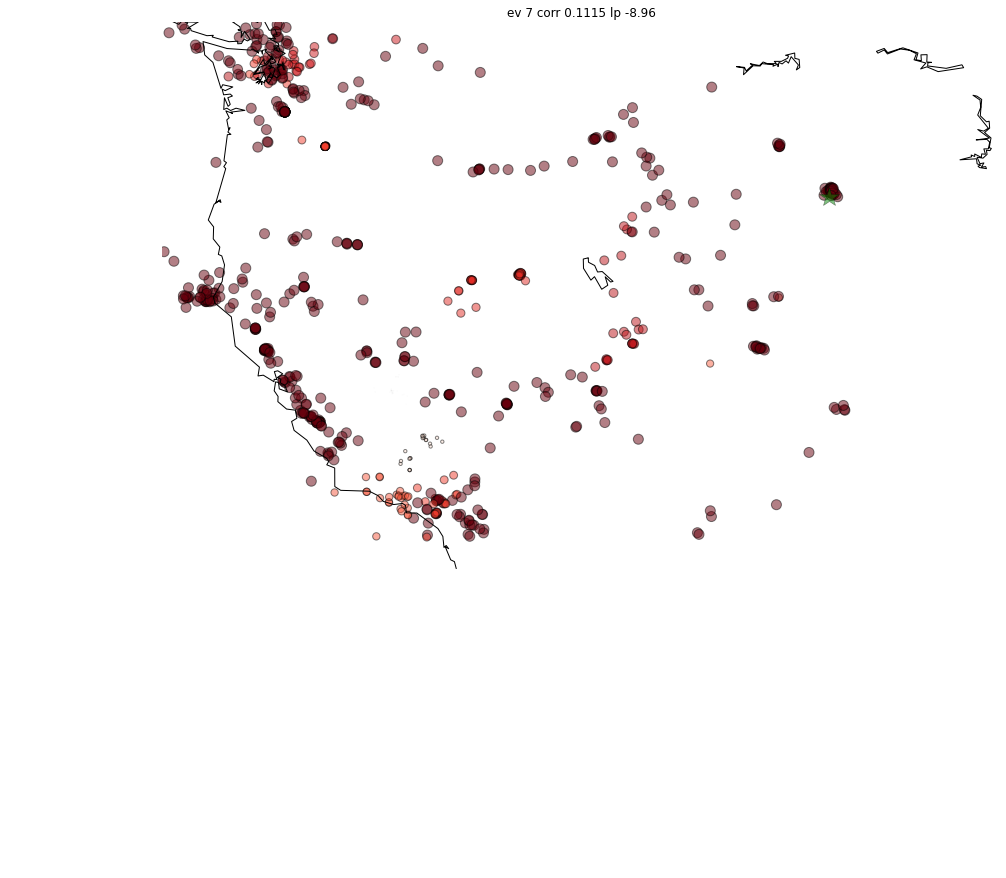

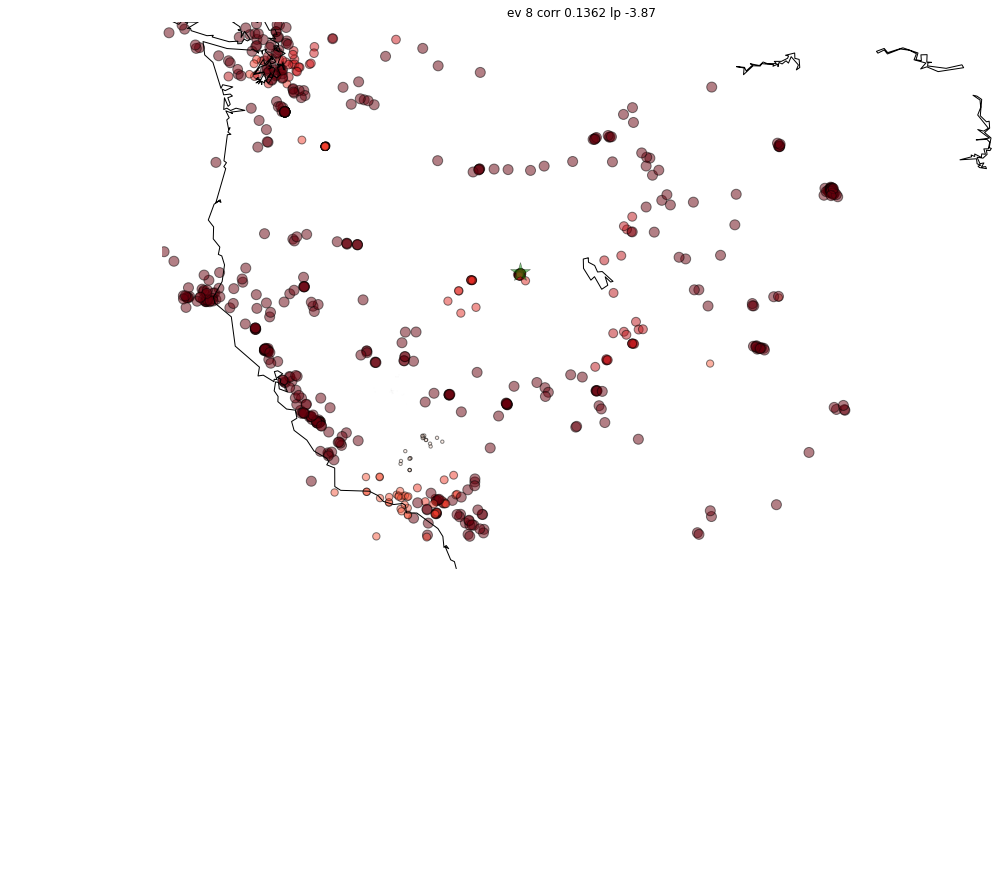

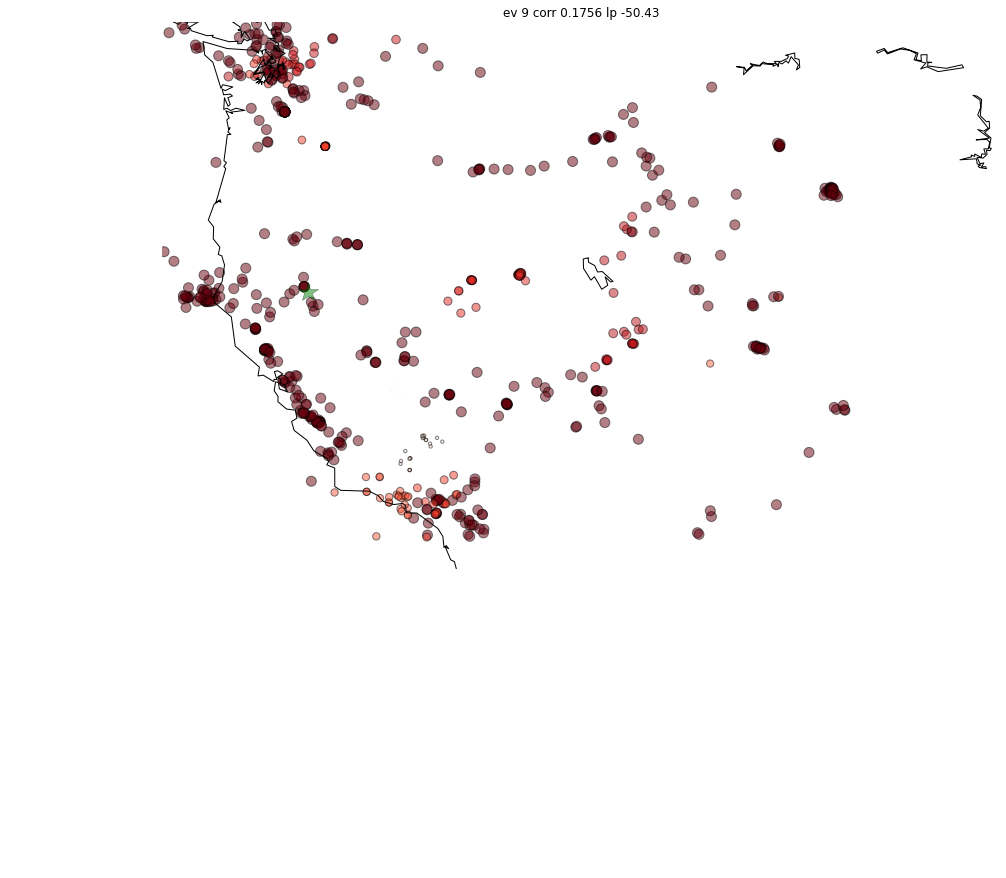

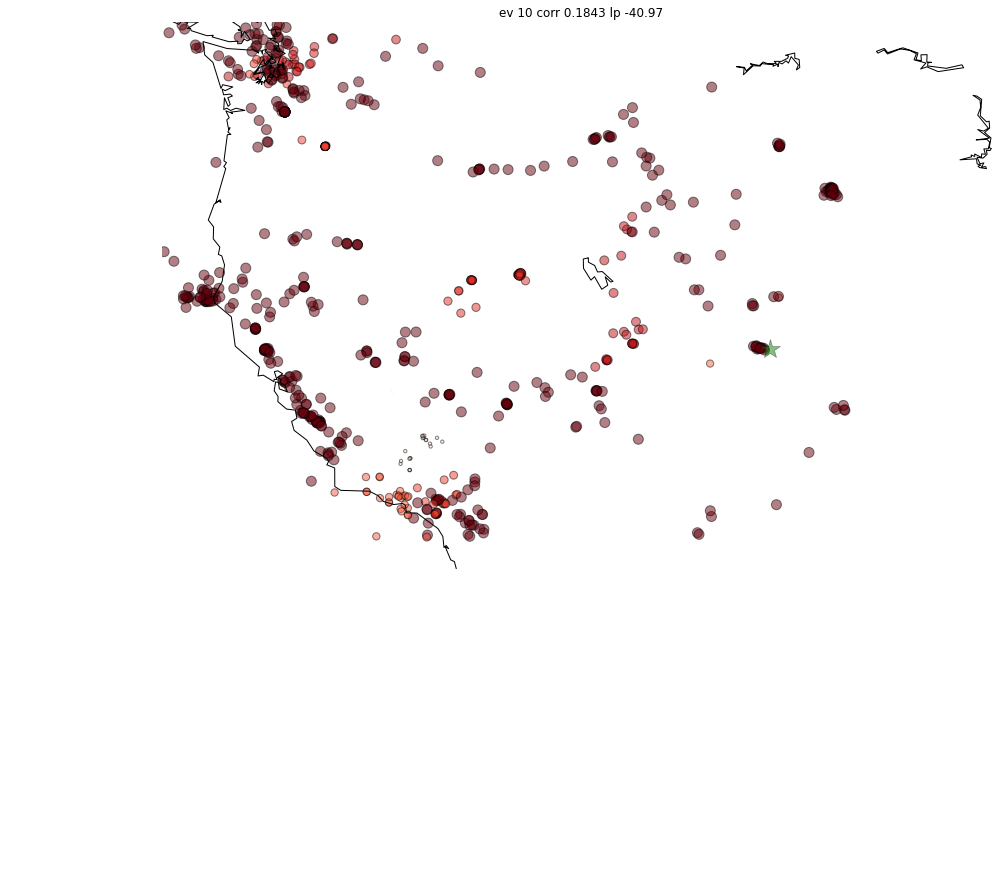

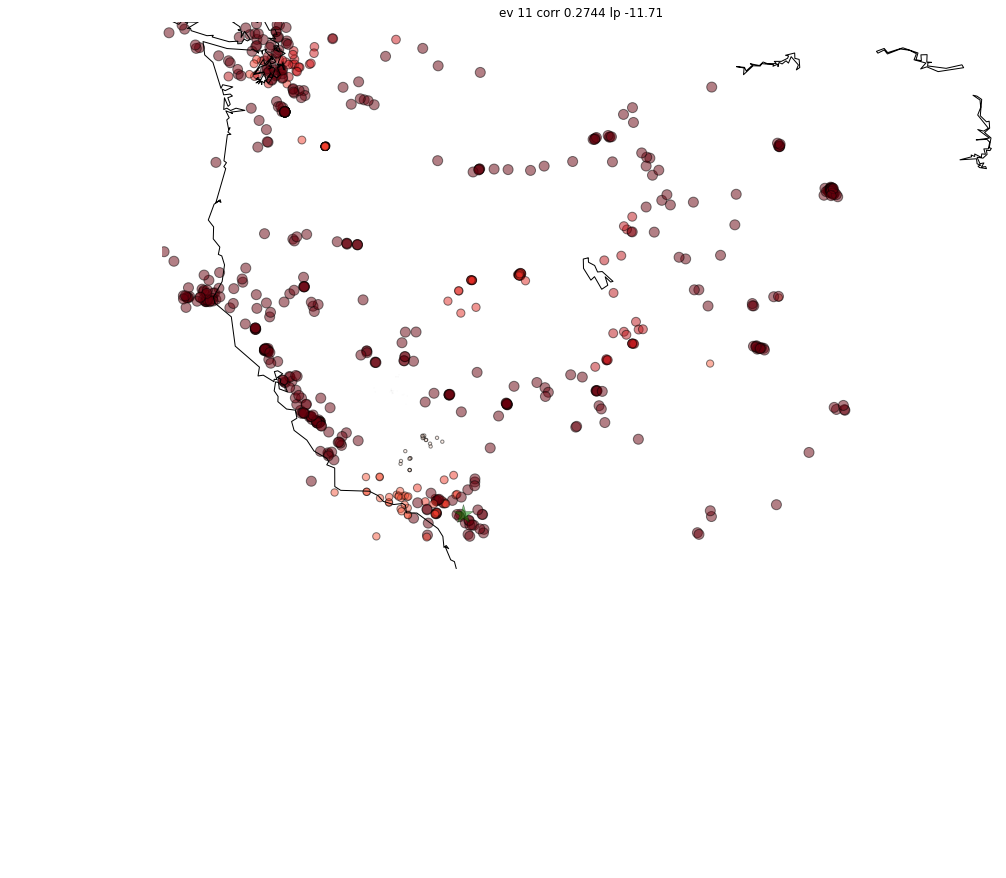

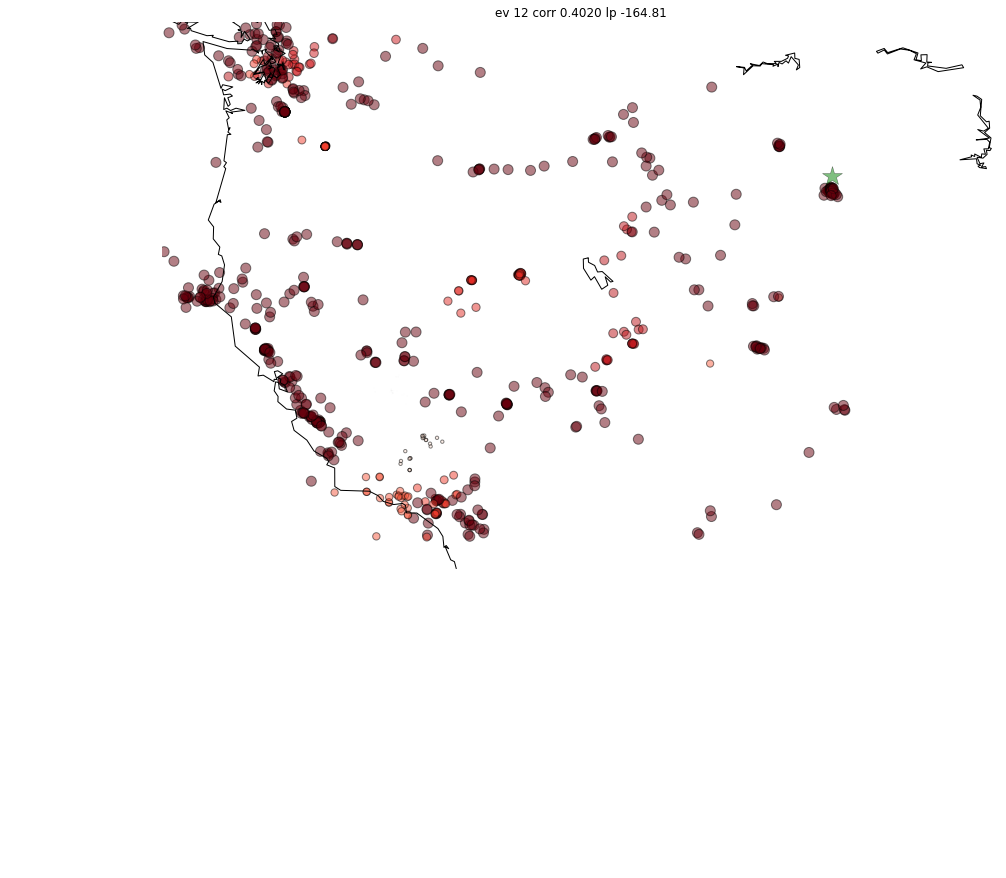

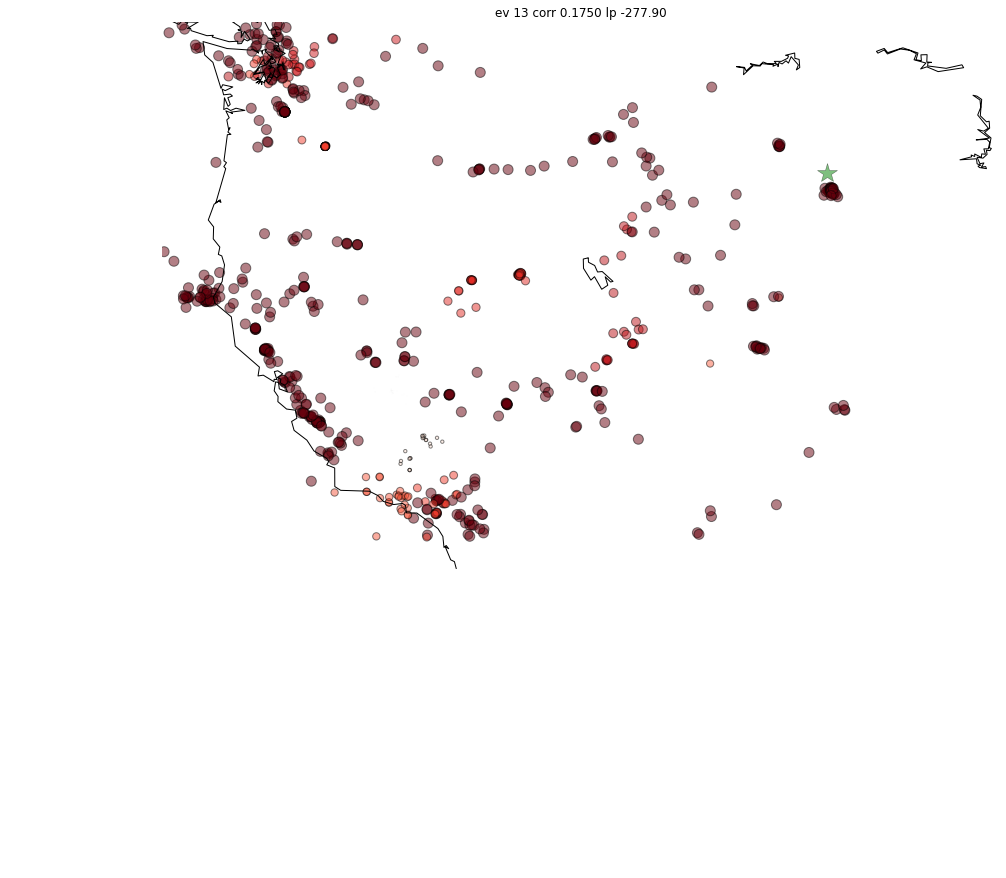

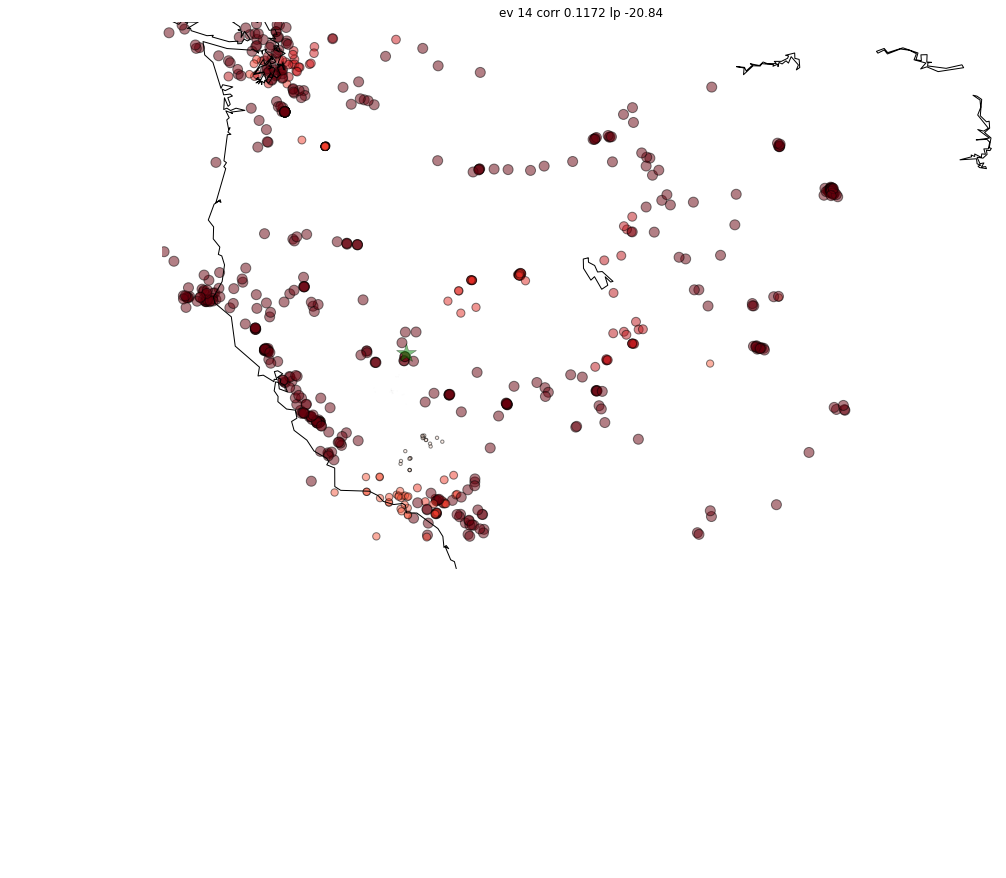

In [156]:
from sigvisa.plotting.event_heatmap import EventHeatmap


def plot_proposal_weights(true_x, training_xs, proposal_weights, stas):
    weights = np.array(proposal_weights)
    scaled_weights = (weights - np.min(weights)) / weights.ptp()
    
    s = Sigvisa()
    hm = EventHeatmap(f=None, calc=False, left_lon=region.left_lon, 
                      right_lon=region.right_lon, bottom_lat=region.bottom_lat, 
                      top_lat=region.top_lat)


    f = plt.figure(figsize=(15, 15))
    ax = f.add_subplot(111)
    sta_locations = [s.earthmodel.site_info(n, 0)[0:2] for n in stas]
    hm.init_bmap(axes=ax)
    hm.plot_locations(sta_locations, labels=stas,
                        marker="^", ms=20, mec="none", mew=0,
                        alpha=1.0, mfc="blue")
    
    
    colors = plt.get_cmap("Reds")(scaled_weights)
    
    hm.plot_locations(true_x, marker="*", ms=20, mfc="green", alpha=0.5)
    
    hm.bmap.scatter(training_xs[:, 0], training_xs[:, 1], marker="o", s=100 * scaled_weights, alpha=0.5, c=colors)
    ax.axis("off")
    return f, ax
    
    
from sigvisa.models.distributions import Gaussian, TruncatedGaussian
def proposal_location_lp(true_x, training_xs, proposal_weights):
    true_lon, true_lat, true_depth = true_x.flatten()[:3]
    londist = Gaussian(true_lon, 0.02)
    latdist = Gaussian(true_lat, 0.02)
    depthdist = TruncatedGaussian(true_depth, 10.0, a=0)
    
    lp = -np.inf
    for x, w in zip(training_xs, proposal_weights):
        lon, lat, depth = x[:3]
        ev_lp = londist.log_p(lon) + latdist.log_p(lat) + depthdist.log_p(depth)
        ev_lp += np.log(w)
        lp = np.logaddexp(lp, ev_lp)
    return lp
    
for i in range(15):
    true_ev = evs[i]
    true_x = np.array(((true_ev.lon, true_ev.lat, true_ev.depth,),))
    f, ax = plot_proposal_weights(true_x, training_xs, pw[i], stas)
    ps = correlated_ps[i].copy()
    ps /= np.linalg.norm(ps)
    ss = correlated_ss[i].copy()
    ss /= np.linalg.norm(ss)
    xc = np.dot(ps, ss)
    
    proposal_lp = proposal_location_lp(true_x, training_xs, pw[i])
    ax.set_title("ev %d corr %.4f lp %.2f" % (i, xc, proposal_lp))